In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 1024

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((75, 75)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

test_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/val"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([1024, 3, 75, 75])
Labels batch shape: torch.Size([1024])


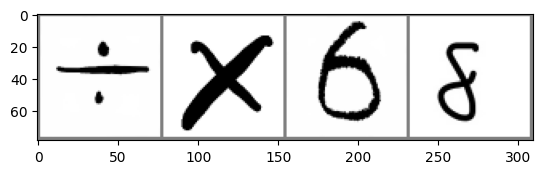

divide	 multiply	 six	 eight	


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [6]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channel, 10, kernel_size=3),
                                    nn.BatchNorm2d(10),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(10, 20, kernel_size=3),
                                    nn.BatchNorm2d(20),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(20, 30, kernel_size=3),
                                    nn.BatchNorm2d(30),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(30, 40, kernel_size=3),
                                    nn.BatchNorm2d(40),
                                    nn.ReLU())


        self.fc1 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(40*5*5, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(4096, 1024),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc5 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 40*5*5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return nn.functional.softmax(x, dim=1)

In [7]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [8]:
for i, l in test_dataloader:
    print(model(i.to(device)).shape)
    break

torch.Size([1024, 14])


In [9]:
def train(model, train_dataloader, optimizer, loss_func):
    losses = []
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        losses.append(loss.item())
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc, losses

In [10]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [11]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 20

In [12]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
all_t_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc, all_t_epoch_losses = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    all_t_losses.append(all_t_epoch_losses)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch 1 of 20
Train


100%|██████████| 42/42 [00:35<00:00,  1.18it/s]


Validation


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Training loss: 2.301, training acc: 45.224
Validation loss: 2.068, validation acc: 68.578
--------------------------------------------------
Epoch 2 of 20
Train


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Training loss: 1.996, training acc: 75.864
Validation loss: 1.943, validation acc: 80.851
--------------------------------------------------
Epoch 3 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Training loss: 1.948, training acc: 80.711
Validation loss: 1.922, validation acc: 83.024
--------------------------------------------------
Epoch 4 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.67it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Training loss: 1.932, training acc: 82.262
Validation loss: 1.908, validation acc: 84.148
--------------------------------------------------
Epoch 5 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Training loss: 1.921, training acc: 83.312
Validation loss: 1.909, validation acc: 84.692
--------------------------------------------------
Epoch 6 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Training loss: 1.916, training acc: 83.841
Validation loss: 1.896, validation acc: 85.291
--------------------------------------------------
Epoch 7 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


Training loss: 1.901, training acc: 85.410
Validation loss: 1.870, validation acc: 88.720
--------------------------------------------------
Epoch 8 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Training loss: 1.863, training acc: 89.118
Validation loss: 1.859, validation acc: 89.189
--------------------------------------------------
Epoch 9 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Training loss: 1.821, training acc: 93.319
Validation loss: 1.790, validation acc: 96.459
--------------------------------------------------
Epoch 10 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Training loss: 1.806, training acc: 94.912
Validation loss: 1.783, validation acc: 97.133
--------------------------------------------------
Epoch 11 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.66it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Training loss: 1.799, training acc: 95.586
Validation loss: 1.793, validation acc: 96.121
--------------------------------------------------
Epoch 12 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Training loss: 1.798, training acc: 95.637
Validation loss: 1.794, validation acc: 96.084
--------------------------------------------------
Epoch 13 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Training loss: 1.797, training acc: 95.831
Validation loss: 1.788, validation acc: 96.477
--------------------------------------------------
Epoch 14 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.67it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Training loss: 1.792, training acc: 96.292
Validation loss: 1.796, validation acc: 95.840
--------------------------------------------------
Epoch 15 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Training loss: 1.790, training acc: 96.472
Validation loss: 1.781, validation acc: 97.114
--------------------------------------------------
Epoch 16 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Training loss: 1.791, training acc: 96.398
Validation loss: 1.783, validation acc: 96.983
--------------------------------------------------
Epoch 17 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Training loss: 1.788, training acc: 96.660
Validation loss: 1.808, validation acc: 94.641
--------------------------------------------------
Epoch 18 of 20
Train


100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Training loss: 1.795, training acc: 95.995
Validation loss: 1.783, validation acc: 97.040
--------------------------------------------------
Epoch 19 of 20
Train


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Training loss: 1.791, training acc: 96.386
Validation loss: 1.785, validation acc: 97.189
--------------------------------------------------
Epoch 20 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

Training loss: 1.789, training acc: 96.531
Validation loss: 1.783, validation acc: 97.452
--------------------------------------------------


In [13]:
#save the trained model weights
torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, 'model.pth')

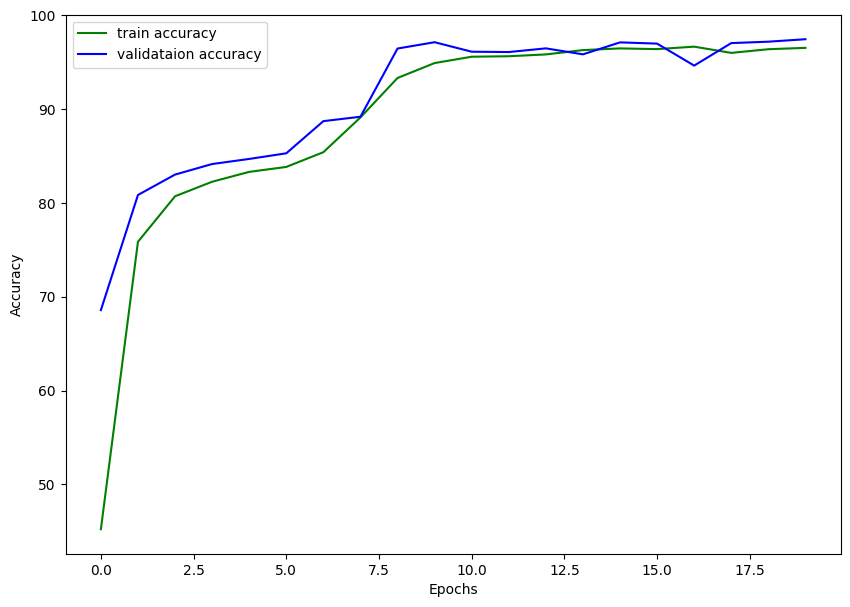

In [14]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

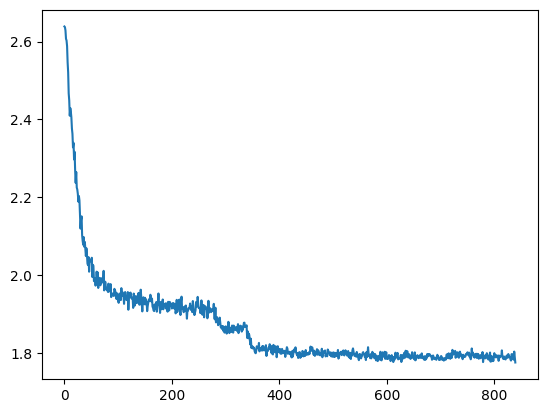

In [15]:
losses = np.array(all_t_losses)
losses =  losses.reshape(len(all_t_losses) * len(all_t_losses[0]))
plt.plot(losses)

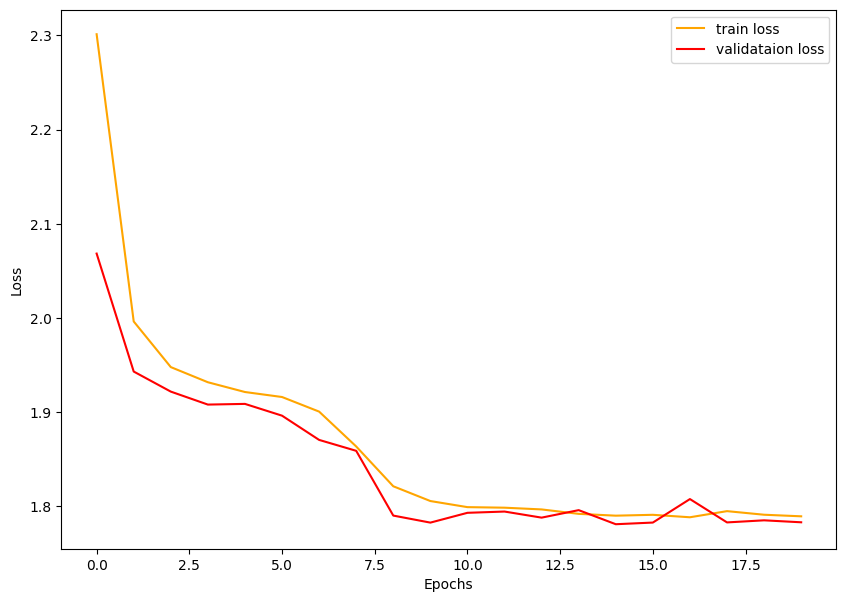

In [16]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

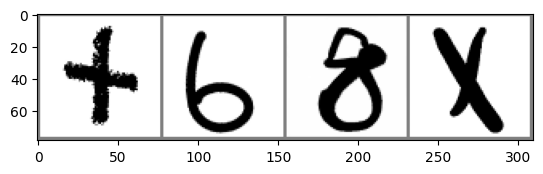

Real value:
add	 six	 eight	 multiply	
Predicted value:
add	 six	 eight	 multiply	


In [17]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 75, 75).to(device)).argmax()]}\t' for j in range(4)))

In [18]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [19]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

              precision    recall  f1-score   support

         add       0.98      0.98      0.98       356
      divide       0.99      1.00      1.00       329
       eight       0.97      0.98      0.98       346
        five       0.98      0.96      0.97       361
        four       0.95      0.99      0.97       383
    multiply       0.99      0.98      0.99       397
        nine       0.96      0.98      0.97       394
         one       0.99      0.96      0.97       473
       seven       0.94      0.98      0.96       390
         six       0.95      0.94      0.94       376
    subtract       1.00      0.99      0.99       438
       three       0.95      0.99      0.97       311
         two       0.97      0.97      0.97       483
        zero       0.98      0.93      0.95       319

    accuracy                           0.97      5356
   macro avg       0.97      0.97      0.97      5356
weighted avg       0.97      0.97      0.97      5356

